# Iris Dataset - SOFENN Example

Demonstrate multi-class classification with SOFENN on classic Iris Dataset

In [1]:
import numpy as np
import random as rnd

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import keras.backend as K
from keras.utils import plot_model
from keras.models import Model, load_model, clone_model

from sofenn import SelfOrganizer
from sofenn.FuzzyNetwork import FuzzyNetwork
from sofenn.layers import FuzzyLayer, NormalizedLayer, WeightedLayer, OutputLayer

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


## Read in and prep Iris Dataset

In [2]:
# read in iris dataset
iris = datasets.load_iris()
# create one-hot encoded vector for each class
Y = []
for y in iris.target:
    tmp = np.zeros(3)
    tmp[y] = 1
    Y.append(tmp)
Y = np.array(Y)
    
# split to train/test
X_train, X_test, y_train, y_test = train_test_split(iris.data, Y, test_size=0.1)

## Create Self Organizer

In [3]:
sofnn = SelfOrganizer(
             ksig=1.12, max_widens=250,          # adding neuron or widening centers
             prune_tol=0.85, k_mae=0.1,          # pruning parameters
             debug=True
                )

### Create Network

In [4]:
start_neurons = 5

sofnn.build_network(
                 X_train, X_test, y_train, y_test,        # data attributes
                 neurons=start_neurons, max_neurons=100,  # neuron initialization parameters
                 ifpart_thresh=0.1354,                    # ifpart and error thresholds
                 prob_type='classification'               # type of problem (classification/regression)
)

network = sofnn.network

Building Fuzzy Network with 5 neurons...
Instructions for updating:
Colocations handled automatically by placer.
...Model successfully built!


### Compile Model

In [5]:
loss = sofnn.network.loss_function
optimizer = 'adam'
metrics = ['binary_accuracy']

sofnn.compile_model(init_c=True, random=True, init_s=True, s_0=4.0,
                    loss=loss, optimizer=optimizer, metrics=metrics)

Compiling model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 4)            0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 5)            40          Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 5)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 5)            25          Inputs[0][0]                     
                                                                 Normalization[0][0]      

### Train model

In [6]:
sofnn.train_model(epochs=45)

Training model...
Instructions for updating:
Use tf.cast instead.
Epoch 1/45
135/135 [==============================] - 1s 7ms/step - loss: 10.0951 - binary_accuracy: 0.6667
Epoch 2/45
135/135 [==============================] - 0s 158us/step - loss: 9.9237 - binary_accuracy: 0.6667
Epoch 3/45
135/135 [==============================] - 0s 226us/step - loss: 9.7942 - binary_accuracy: 0.6667
Epoch 4/45
135/135 [==============================] - 0s 171us/step - loss: 9.6762 - binary_accuracy: 0.6667
Epoch 5/45
135/135 [==============================] - 0s 165us/step - loss: 9.5179 - binary_accuracy: 0.6667
Epoch 6/45
135/135 [==============================] - 0s 116us/step - loss: 9.4245 - binary_accuracy: 0.6667
Epoch 7/45
135/135 [==============================] - 0s 127us/step - loss: 9.3056 - binary_accuracy: 0.6667
Epoch 8/45
135/135 [==============================] - 0s 164us/step - loss: 9.2553 - binary_accuracy: 0.6691
Epoch 9/45
135/135 [==============================] - 0s 170us/

In [7]:
c,s = sofnn.new_neuron_weights()

In [8]:
c

array([6.17460155, 2.63537169, 4.70471907, 1.20740741])

In [9]:
s

array([3.74021173, 3.73521066, 3.74612689, 2.56277739])

In [10]:
y_pred = network.model_predictions()
y_pred

array([[0.70458376, 0.24958563, 0.04583054],
       [0.3205753 , 0.32485333, 0.35457137],
       [0.4280763 , 0.33535153, 0.23657215],
       [0.2631178 , 0.3079046 , 0.42897755],
       [0.13931516, 0.2371169 , 0.623568  ],
       [0.03515735, 0.11200634, 0.8528363 ],
       [0.6905203 , 0.25775394, 0.05172572],
       [0.67147803, 0.26817077, 0.06035115],
       [0.66590637, 0.27107814, 0.06301539],
       [0.0941669 , 0.1946038 , 0.71122926],
       [0.65422624, 0.2769661 , 0.06880766],
       [0.6658402 , 0.27111235, 0.06304745],
       [0.15690224, 0.2507127 , 0.59238505],
       [0.1704897 , 0.26028073, 0.56922954],
       [0.16169722, 0.254178  , 0.58412474]], dtype=float32)

In [11]:
sofnn.widen_centers()


Widening centers...
Centers widened after 0 iterations


### Test neuron pruning

In [12]:
network.neurons

5

### Create copy model

In [18]:
prune_model = clone_model(network.model)
prune_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 4)            0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 5)            40          Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 5)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 5)            25          Inputs[0][0]                     
                                                                 Normalization[0][0]              
__________

In [15]:
E_rmse = mean_squared_error(network.y_test, y_pred)
E_rmse

0.15689440585337014

In [16]:
act_weights = network.model.get_weights()
act_weights

[array([[ 6.3696566 ,  4.603665  ,  5.1672697 ,  6.9880404 ,  6.922022  ],
        [ 2.5602474 ,  3.4443538 ,  3.5287325 ,  2.9069643 ,  2.867683  ],
        [ 4.269643  ,  1.3399494 ,  1.2576641 ,  5.8979626 ,  4.9017005 ],
        [ 1.5707487 , -0.05153421,  0.15369044,  2.693892  ,  1.6926484 ]],
       dtype=float32),
 array([[3.7421691, 3.745316 , 3.7486923, 3.6966   , 3.7478955],
        [3.7193928, 4.199241 , 3.9959254, 3.7569969, 3.73914  ],
        [3.7529328, 3.7179635, 3.743473 , 3.6929634, 3.7371545],
        [3.7818456, 3.7100377, 3.7327769, 3.6916182, 3.6920516]],
       dtype=float32),
 array([[ 1.05593232e-02, -2.27281332e-01, -2.09979936e-01,
          7.50357881e-02,  7.80951381e-02],
        [ 6.46460354e-02, -2.60521203e-01, -1.65035546e-01,
          1.42984614e-01,  5.43518737e-02],
        [-1.82116944e-02, -2.64333963e-01, -1.87058493e-01,
          1.24080576e-01,  2.01590854e-04],
        [ 1.56993359e-01,  5.01807891e-02, -1.33926068e-02,
          1.63400292

ValueError: Unknown layer: FuzzyLayer

In [ ]:
delta_E = []
for neur in range(network.neurons):
    # reset prune model weights to actual weights
    prune_model.set_weights(act_weights)

    # get current prune weights
    c, s, a = prune_model.get_weights()
    # zero our i neuron column in weight vector
    a[:, neur] = 0
    prune_model.set_weights([c, s, a])

    # predict values with new zeroed out weights
    neur_pred = prune_model.predict(fuzzy_net.X_test)
    y_pred_neur = np.squeeze(np.where(neur_pred >= self._eval_thresh, 1, 0), axis=-1)
    neur_rmae = mean_absolute_error(fuzzy_net.y_test, y_pred_neur)

    # append difference in rmse and new prediction rmse
    delta_E.append(neur_rmae - E_rmae)


In [14]:
sofnn.add_neuron()


Adding neuron...
Building Fuzzy Network with 6 neurons...
...Model successfully built!
Training model...


RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

In [4]:
# loss = 'mean_squared_error'
loss = fuzz.loss_function
optimizer = 'adam'
metrics = ['binary_accuracy']

model = fuzz.model

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

model.fit(np.array(X_train),
          np.array(y_train),
          epochs=250,
          verbose=1,
          batch_size=2)

Epoch 1/250
135/135 [==============================] - 1s 7ms/step - loss: 0.6707 - binary_accuracy: 0.6667
Epoch 2/250
135/135 [==============================] - 0s 1ms/step - loss: 0.6608 - binary_accuracy: 0.6667
Epoch 3/250
135/135 [==============================] - 0s 1ms/step - loss: 0.6566 - binary_accuracy: 0.6667
Epoch 4/250
135/135 [==============================] - 0s 1ms/step - loss: 0.6520 - binary_accuracy: 0.6667
Epoch 5/250
135/135 [==============================] - 0s 1ms/step - loss: 0.6440 - binary_accuracy: 0.6667
Epoch 6/250
135/135 [==============================] - 0s 1ms/step - loss: 0.6330 - binary_accuracy: 0.6667
Epoch 7/250
135/135 [==============================] - 0s 1ms/step - loss: 0.6170 - binary_accuracy: 0.6667
Epoch 8/250
135/135 [==============================] - 0s 1ms/step - loss: 0.5963 - binary_accuracy: 0.6691
Epoch 9/250
135/135 [==============================] - 0s 1ms/step - loss: 0.5758 - binary_accuracy: 0.7086
Epoch 10/250
135/135 [======

135/135 [==============================] - 0s 1ms/step - loss: 0.0377 - binary_accuracy: 0.9852
Epoch 151/250
135/135 [==============================] - 0s 1ms/step - loss: 0.0384 - binary_accuracy: 0.9802
Epoch 152/250
135/135 [==============================] - 0s 1ms/step - loss: 0.0380 - binary_accuracy: 0.9852
Epoch 153/250
135/135 [==============================] - 0s 1ms/step - loss: 0.0370 - binary_accuracy: 0.9852
Epoch 154/250
135/135 [==============================] - 0s 1ms/step - loss: 0.0376 - binary_accuracy: 0.9852
Epoch 155/250
135/135 [==============================] - 0s 1ms/step - loss: 0.0372 - binary_accuracy: 0.9852
Epoch 156/250
135/135 [==============================] - 0s 1ms/step - loss: 0.0372 - binary_accuracy: 0.9852
Epoch 157/250
135/135 [==============================] - 0s 1ms/step - loss: 0.0374 - binary_accuracy: 0.9852
Epoch 158/250
135/135 [==============================] - 0s 1ms/step - loss: 0.0373 - binary_accuracy: 0.9852
Epoch 159/250
135/135 [=

In [5]:
fuzz._get_layer_weights('FuzzyRules')

[array([[ 6.1073303,  5.8863463,  3.8469965],
        [ 2.4748902,  4.0579185,  1.1891739],
        [ 6.9911284,  1.0462298,  3.7106006],
        [ 3.7091155, -0.3453039,  2.5200057]], dtype=float32),
 array([[3.9457917, 5.1618943, 2.0746884],
        [3.2234733, 3.435901 , 2.1246395],
        [2.0414689, 3.5269158, 2.0570922],
        [1.4811075, 2.9864326, 1.6324853]], dtype=float32)]

In [6]:
X_test

array([[5. , 3.6, 1.4, 0.2],
       [6.3, 2.9, 5.6, 1.8],
       [6.6, 3. , 4.4, 1.4],
       [4.6, 3.6, 1. , 0.2],
       [5.9, 3.2, 4.8, 1.8],
       [5.9, 3. , 4.2, 1.5],
       [5.7, 3. , 4.2, 1.2],
       [6.9, 3.1, 4.9, 1.5],
       [4.8, 3. , 1.4, 0.3],
       [7.4, 2.8, 6.1, 1.9],
       [5.1, 3.5, 1.4, 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [6.4, 2.7, 5.3, 1.9],
       [6.1, 2.9, 4.7, 1.4],
       [4.8, 3.1, 1.6, 0.2]])

In [7]:
y_test

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [8]:
y_pred = model.predict(X_test)
y_pred.round()

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [9]:
acc = y_test == y_pred.round()
acc

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True, False, False],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [10]:
acc.sum() / acc.size

0.9555555555555556

## Model Prediction Results

In [11]:
pred_loss, pred_bin_acc = model.evaluate(X_test, y_test)
print('Model Loss: {:0.8f}'.format(pred_loss))
print('Binary Accuracy: {:2.1f}%'.format(100*pred_bin_acc))

15/15 [==============================] - 0s 9ms/step
Model Loss: 0.43104896
Binary Accuracy: 95.6%


In [12]:
model.metrics_names

['loss', 'binary_accuracy']

## Plot Results

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


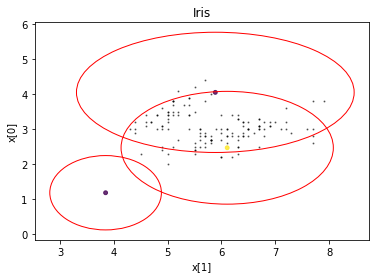

In [13]:
w = fuzz._get_layer_weights('FuzzyRules')


plt.clf()
plt.title('Iris')
plt.ylabel('x[0]')
plt.xlabel('x[1]')
plt.scatter([a[0] for a in X_train], [a[1] for a in X_train], c=(0,0,0), alpha=0.5,s=1)
for i in range(0,fuzz.neurons):
    ellipse = Ellipse((w[0][0][i], w[0][1][i]), w[1][0][i],w[1][1][i], color='r', fill=False)
    ax = plt.gca()
    ax.add_patch(ellipse)

plt.scatter(w[0][0], w[0][1], c=(1,0,0), alpha=0.8,s=15)
plt.show()